In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


In [2]:
# leer los datos desde un archivo Excel
df = pd.read_excel('COES15_23_ENT.xlsx', header=1)
df = df[['FECHA', 'KW','Prog_D']]
df.set_index('FECHA', inplace=True) # convertimos la columna Fecha como indice
df.index = pd.to_datetime(df.index,format="%d/%m/%Y %H:%M") # transformar el indice Fecha a datetime
df = df.asfreq('30min') # frecuencia de datos cada 30 Minutos
df = df.sort_index() # ordenar indice
df

,KW,Prog_D
FECHA,,
2015-01-01 00:30:00,4557.59715,4437.90959
2015-01-01 01:00:00,4483.13816,4287.75745
2015-01-01 01:30:00,4319.24372,4213.42973
2015-01-01 02:00:00,4226.42943,4093.82949
2015-01-01 02:30:00,4179.29111,4012.68241
...,...,...
2023-03-07 21:30:00,7433.11750,7342.71278
2023-03-07 22:00:00,7301.49613,7309.33338
2023-03-07 22:30:00,7289.22840,7237.50325


<AxesSubplot:>

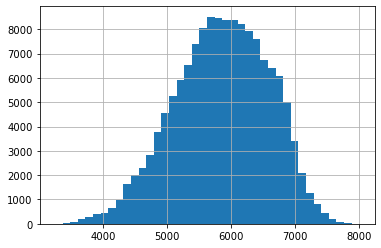

In [3]:
df.KW.hist(bins=40)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143423 entries, 2015-01-01 00:30:00 to 2023-03-07 23:30:00
Freq: 30T
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   KW      143423 non-null  float64
 1   Prog_D  143423 non-null  float64
dtypes: float64(2)
memory usage: 3.3 MB


In [5]:
df['dia']=df.index.day_of_week
df['mes']=df.index.month

In [6]:
df

,KW,Prog_D,dia,mes
FECHA,,,,
2015-01-01 00:30:00,4557.59715,4437.90959,3,1
2015-01-01 01:00:00,4483.13816,4287.75745,3,1
2015-01-01 01:30:00,4319.24372,4213.42973,3,1
2015-01-01 02:00:00,4226.42943,4093.82949,3,1
2015-01-01 02:30:00,4179.29111,4012.68241,3,1
...,...,...,...,...
2023-03-07 21:30:00,7433.11750,7342.71278,1,3
2023-03-07 22:00:00,7301.49613,7309.33338,1,3
2023-03-07 22:30:00,7289.22840,7237.50325,1,3


In [7]:
sc= MinMaxScaler()
df_scaled = sc.fit_transform(df)

n_steps_in=20   #Pasos de entrada
n_steps_out=6  #Pasos de salida
feature=4     # Caracteristicas

In [8]:
# Dividir secuencias multivariable en muestras
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# encuentra en fin del patron
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# verifica si llegamos al final del conjunto de datos
		if out_end_ix > len(sequences):
			break
		# obtener secuencias de entrada y salida
		seq_x, seq_y = sequences[i:end_ix, :feature], sequences[end_ix:out_end_ix, -feature]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [9]:
#obtener secuencias
X, y = split_sequences(df_scaled, n_steps_in, n_steps_out)

In [10]:
X.shape

(143398, 20, 4)

In [11]:
y.shape

(143398, 6)

In [12]:
X3_train, y3_train = X[:130000], y[:130000]
X3_val, y3_val = X[130000:135000], y[130000:135000]
X3_test, y3_test = X[135000:], y[135000:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((130000, 20, 4),
 (130000, 6),
 (5000, 20, 4),
 (5000, 6),
 (8398, 20, 4),
 (8398, 6))

In [13]:
model5 = Sequential()
model5.add(LSTM(32,input_shape=(n_steps_in, feature)))
model5.add(Dense(n_steps_out, 'relu'))

model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 4,934
Trainable params: 4,934
Non-trainable params: 0
_________________________________________________________________


In [14]:
cp5 = ModelCheckpoint('model5/', monitor='loss',save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [15]:
X.shape

(143398, 20, 4)

In [16]:
y.shape

(143398, 6)

In [17]:
model5.fit(X3_train, y3_train, epochs=, callbacks=[cp5], batch_size=32)

Epoch 1/10
4057/4063 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0709

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


4063/4063 [==============================] - 27s 6ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709
Epoch 2/10
4059/4063 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0426

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


4063/4063 [==============================] - 25s 6ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426
Epoch 3/10
4059/4063 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0343

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


4063/4063 [==============================] - 25s 6ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342
Epoch 4/10
4055/4063 [============================>.] - ETA: 0s - loss: 9.3932e-04 - root_mean_squared_error: 0.0306

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


4063/4063 [==============================] - 25s 6ms/step - loss: 9.3924e-04 - root_mean_squared_error: 0.0306
Epoch 5/10
4059/4063 [============================>.] - ETA: 0s - loss: 8.3499e-04 - root_mean_squared_error: 0.0289

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


4063/4063 [==============================] - 26s 6ms/step - loss: 8.3491e-04 - root_mean_squared_error: 0.0289
Epoch 6/10
4061/4063 [============================>.] - ETA: 0s - loss: 7.6357e-04 - root_mean_squared_error: 0.0276

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


4063/4063 [==============================] - 25s 6ms/step - loss: 7.6356e-04 - root_mean_squared_error: 0.0276
Epoch 7/10
4062/4063 [============================>.] - ETA: 0s - loss: 7.1399e-04 - root_mean_squared_error: 0.0267

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


4063/4063 [==============================] - 26s 6ms/step - loss: 7.1396e-04 - root_mean_squared_error: 0.0267
Epoch 8/10
4058/4063 [============================>.] - ETA: 0s - loss: 6.6331e-04 - root_mean_squared_error: 0.0258

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


4063/4063 [==============================] - 28s 7ms/step - loss: 6.6328e-04 - root_mean_squared_error: 0.0258
Epoch 9/10
4055/4063 [============================>.] - ETA: 0s - loss: 6.2890e-04 - root_mean_squared_error: 0.0251

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


4063/4063 [==============================] - 28s 7ms/step - loss: 6.2900e-04 - root_mean_squared_error: 0.0251
Epoch 10/10
4055/4063 [============================>.] - ETA: 0s - loss: 5.9676e-04 - root_mean_squared_error: 0.0244

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


4063/4063 [==============================] - 27s 7ms/step - loss: 5.9684e-04 - root_mean_squared_error: 0.0244


In [18]:
model5.history.history.keys()

dict_keys(['loss', 'root_mean_squared_error'])

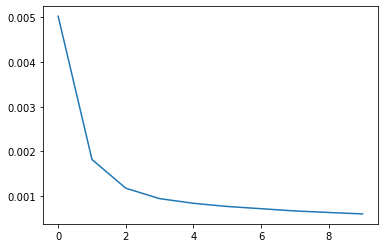

In [19]:
loss_per_epoch = model5.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [20]:

pred=model5.predict(X3_test)

263/263 [==============================] - 1s 3ms/step


In [21]:

## create empty table with 12 fields
tab1 = np.zeros(shape=(len(pred), feature) )
# put the predicted values in the right field
tab1[:,0] = pred[:,0]
# inverse transform and then select the right field
predict1 = sc.inverse_transform(tab1)[:,0]

tab2 = np.zeros(shape=(len(y3_test), feature) )
# put the predicted values in the right field
tab2[:,0] = y3_test[:,0]
# inverse transform and then select the right field
y3_test = sc.inverse_transform(tab2)[:,0]


print("predict1 :",predict1)
print("y3test :",y3_test)


predict1 : [7026.52485508 6875.6966446  6590.17260493 ... 7601.97710142 7621.43334493
 7647.35301561]
y3test : [6961.92908 6708.69469 6526.24372 ... 7578.43744 7564.47105 7511.62486]


In [22]:
df3 = pd.DataFrame({'KW Predictions':predict1.flatten(),'KW Actuals':y3_test.flatten()})

In [23]:
df3

,KW Predictions,KW Actuals
0,7026.524855,6961.92908
1,6875.696645,6708.69469
2,6590.172605,6526.24372
3,6436.763666,6378.10812
4,6325.516056,6168.06825
...,...,...
8393,7368.755270,7618.81189
8394,7666.157283,7605.38267
8395,7601.977101,7578.43744
8396,7621.433345,7564.47105


In [24]:
# convertir el índice a un objeto DateTimeIndex y establecer una frecuencia de 30 minutos
df3.index = pd.date_range(start='2022-09-13 11:00', periods=len(df3), freq='30T')

df3

,KW Predictions,KW Actuals
2022-09-13 11:00:00,7026.524855,6961.92908
2022-09-13 11:30:00,6875.696645,6708.69469
2022-09-13 12:00:00,6590.172605,6526.24372
2022-09-13 12:30:00,6436.763666,6378.10812
2022-09-13 13:00:00,6325.516056,6168.06825
...,...,...
2023-03-07 07:30:00,7368.755270,7618.81189
2023-03-07 08:00:00,7666.157283,7605.38267
2023-03-07 08:30:00,7601.977101,7578.43744
2023-03-07 09:00:00,7621.433345,7564.47105


In [25]:
df3.columns

Index(['KW Predictions', 'KW Actuals'], dtype='object')

In [46]:
df_sel = df3.loc[df3.index[0:200]]


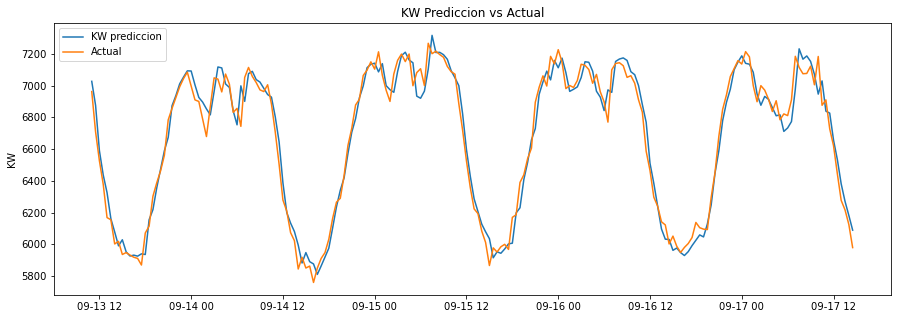

In [49]:
# graficar los datos
# df_sel = df3.loc[df3.index[0:5]]
plt.figure(figsize=(15,5))
plt.plot(df_sel.index, df_sel["KW Predictions"], label="KW prediccion")
plt.plot(df_sel.index, df_sel["KW Actuals"], label="Actual")

# establecer etiquetas de eje y título
plt.ylabel("KW")
plt.title("KW Prediccion vs Actual")

# establecer leyenda
plt.legend()

# mostrar el gráfico
plt.show()

In [29]:
df3.columns


Index(['KW Predictions', 'KW Actuals'], dtype='object')

In [52]:
import sklearn.metrics as metrics
r2 = metrics.r2_score(y3_test, predict1)

print("r2 : ", r2.round(4))

r2 :  0.9701
